# 1. Define genetic algorithm suite

In [1]:
from sklearn.gaussian_process.kernels import RBF

from src.prediction.regression.trainers.gpr_model_trainer import GPRModelTrainer

from src.ga.chromosome.vent_hole import VentHole

from src.ga.gene.shape.shape_variations import (
    circle_params,
    arrow_params,
    parabola_x_right_inner_multi_params,
    parabola_x_right_inner_params,
    wing_params,
    rose_params,
    flower_params,
    diamond_params,
    hexagon_params,
    triangle_params,
    trapezoid_params,
    triple_rectangle_params,
)
from src.ga.gene.pattern.pattern_variations import (
    circular_params,
    corn_params,
    grid_params,
)

from src.ga.ga_pipeline import GAPipeline

from src.ga.p1_initialize.init_vent import VentInitializer
from src.ga.p2_fitness.vent_fitness import Criterion, VentFitnessCalculator
from src.ga.p3_select.behaviors import (
    TournamentSelectionFilter,
    ElitismSelectionFilter,
    RouletteWheelSelectionFilter,
)
from src.ga.p4_crossover.behaviors import (
    OnePointCrossover,
    TwoPointCrossover,
    UniformCrossover,
)

# ----------------- Define the GA CONSTANTS -----------------
# 1. Define the criteria weights, w1, w2, w3
CRITERIA_WEIGHT = (1, 1, 1)

# 2. Define the criteria with direction, min, and max values
DRAG_CRITERION: Criterion = ("lower", 0.2, 0.3)  # Lower is better, range 0.2 to 0.3
DRAG_STD_CRITERION: Criterion = ("lower", 0, 0.05)  # Lower is better, range 0 to 0.05

AVG_TEMP_CRITERION: Criterion = (
    "lower",
    300,
    400,
)  # Lower is better, range 250K to 400K
AVG_TEMP_STD_CRITERION: Criterion = ("lower", 0, 10)  # Lower is better, range 0K to 10K

MAX_TEMP_CRITERION: Criterion = (
    "lower",
    400,
    475,
)  # Lower is better, range 300K to 500K
MAX_TEMP_STD_CRITERION: Criterion = ("lower", 0, 10)  # Lower is better, range 0K to 10K

# 3. Define the grid parameters
GRID_SCALE = 1
# Scaling factor

GRID_RESOLUTION = 2
# Grid resolution

GRID_WIDTH = 75
# Grid width, ~= canvas size

GRID_BOUND = (
    (-GRID_WIDTH / 2, GRID_WIDTH / 2),
    (-GRID_WIDTH / 2, GRID_WIDTH / 2),
)
# ----------------- Define the GA MODELS -----------------

gpr_kernel = RBF(1.0, (1e-2, 1e2))
gpr_model_trainer = GPRModelTrainer(
    gpr_kernel=gpr_kernel,
    gpr_drag_config=(10, 1e-5),
    gpr_max_temp_config=(10, 1e-3),
    gpr_avg_temp_config=(10, 1e-3),
    grid_bound=GRID_BOUND,
    grid_bound_width=GRID_WIDTH,
    grid_resolution=GRID_RESOLUTION,
    grid_scale=GRID_SCALE,
    desired_variance=0.975,
)

# ----------------- Define the GA PIPELINES -----------------
suite = GAPipeline[VentHole](
    suite_name="exp/tournament/config",
    suite_max_count=50,
    suite_min_population=20,
    suite_min_chromosome=40,
    crossover_behavior=UniformCrossover(),
    selector_behavior=TournamentSelectionFilter(tournament_size=4),
    fitness_calculator=VentFitnessCalculator(
        model_trainer_tuple=(
            gpr_model_trainer,
            gpr_model_trainer,
            gpr_model_trainer,
        ),
        criteria_weight_list=CRITERIA_WEIGHT,
        drag_criterion=DRAG_CRITERION,
        drag_std_criterion=DRAG_STD_CRITERION,
        avg_temp_criterion=AVG_TEMP_CRITERION,
        avg_temp_std_criterion=AVG_TEMP_STD_CRITERION,
        max_temp_criterion=MAX_TEMP_CRITERION,
        max_temp_std_criterion=MAX_TEMP_STD_CRITERION,
    ),
    immediate_exit_condition=lambda x: x[0] >= 1.25 or x[1] >= 1.25,
    mutation_probability=0.01,  # 1%
    population_initializer=VentInitializer(
        population_size=150,
        grid_scale=GRID_SCALE,
        grid_resolution=GRID_RESOLUTION,
        pattern_bound=GRID_BOUND,
        pattern_gene_pool=[
            circular_params,
            corn_params,
            grid_params,
        ],
        shape_gene_pool=[
            circle_params,
            arrow_params,
            parabola_x_right_inner_multi_params,
            parabola_x_right_inner_params,
            wing_params,
            rose_params,
            flower_params,
            diamond_params,
            hexagon_params,
            triangle_params,
            trapezoid_params,
            triple_rectangle_params,
        ],
    ),
)

[Storage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/gene_parameters.json
[Storage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/gene_parameters.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/shape_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/shape_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/shape_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/pattern_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/pattern_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/pattern_gene_pdf.json
--------------------------------------
| [ModelTrainer]: Model Trainer: GPR |
--------------------------------------
---------------

/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


-----------------------------------------------
| [ModelTrainer]: Training set found, loading |
-----------------------------------------------
----------------------------------------------------
| [ModelTrainer]: PCA optimal founding initialized |
----------------------------------------------------
---------------------------------------------------------------------------------
| [ModelTrainer]: Optimal feature count founded: 67 for desired variance: 0.975 |
---------------------------------------------------------------------------------
-----------------------------------------------
| [ModelTrainer]: Training set found, loading |
-----------------------------------------------


/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


-----------------------------------------------
| [ModelTrainer]: Training set found, loading |
-----------------------------------------------


/Users/june/Documents/project/capstone_1/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[Storage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/gene_parameters.json
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/shape_gene_pdf.json
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/pattern_gene_pdf.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/exp/tournament/config/fitness_evolution.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/exp/tournament/config/fitness_evolution.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/exp/tournament/config/fitness_evolution.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/exp/tournament/config/biased_fitness_evolution.json
[StochasticStorage]: JSON data loaded from /Users/june/Documents/project/capstone_1/store/exp/tournament/config/biased_fitness_evolution.js

# 2. Run genetic algorithm

매번 run을 실행할 때마다, 개체 수, 격자 해상도 등에 따라 다르지만, **수행 시간이 길 수 있습니다.**

# 2. Run genetic algorithm

매번 run을 실행할 때마다, 개체 수, 격자 해상도 등에 따라 다르지만, **수행 시간이 길 수 있습니다.**

In [2]:
suite.run()

----------------------------------------------------------------------------------------------------
>> GA started
----------------------------------------------------------------------------------------------------
Suite_name: exp/tournament/config
Generation: 0
Population_count: 0
Mutation_count: 0
Immediate_exit: False
Initial_population: 150
Unique_population_count: 0
Suite_max_count: 50
Suite_min_population: 20
Suite_min_chromosome: 40
Use_cache: True
Check_children_fitness: True
Mutation_probability: 0.01
Fitness_calculator: GPR
Selector_behavior: TournamentSelection
Crossover_behavior: Uniform Crossover
Population_initializer: VentInitializer
----------------------------------------------------------------------------------------------------
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/exp/tournament/config/fitness_evolution.json
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/exp/tournament/config/

/Users/june/Documents/project/capstone_1/src/ga/gene/shape/shape_variations.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  return x >= (y**2) / b - a and x <= a
/Users/june/Documents/project/capstone_1/src/ga/gene/shape/shape_variations.py:51: RuntimeWarning: invalid value encountered in scalar divide
  return x >= (y**2) / b - a and x <= a
/Users/june/Documents/project/capstone_1/src/ga/gene/shape/shape_variations.py:70: RuntimeWarning: divide by zero encountered in scalar divide
  return x >= (y**2) / b1 - a1 and x <= y**2 / b2 - a2 and x <= 10
/Users/june/Documents/project/capstone_1/src/ga/gene/shape/shape_variations.py:70: RuntimeWarning: invalid value encountered in scalar divide
  return x >= (y**2) / b1 - a1 and x <= y**2 / b2 - a2 and x <= 10


[Storage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/gene_parameters.json
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/shape_gene_pdf.json
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/pattern_gene_pdf.json
----------------------------------------------------------------------------------------------------
>> Generation: 0, Population: 150, Unique population: 150, Should Stop: False
----------------------------------------------------------------------------------------------------
[PopulationStorage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/exp/tournament/config/population.json
[StochasticStorage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/exp/tournament/config/fitness.json
[Storage]: JSON data saved to /Users/june/Documents/project/capstone_1/store/gene_parameters.json
[StochasticStorage]: JSON data saved to /Users/june/Documents

# 3. Plot fitness result

- `biased_fitness`: 가중치가 적용된 fitness, $w1 * p1 + w2 * p2+ ...$
- `fitness`: 가중치 없이 계산된 fitness, $p1 + p2 + ...$

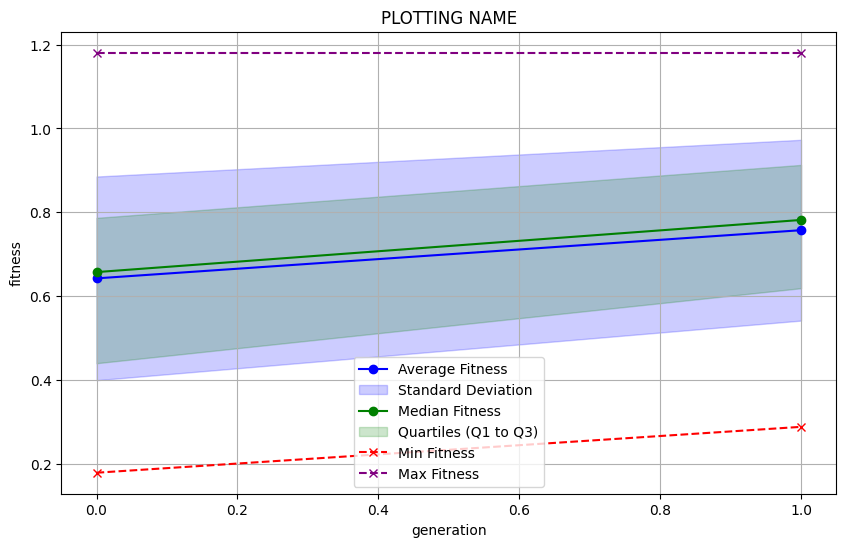

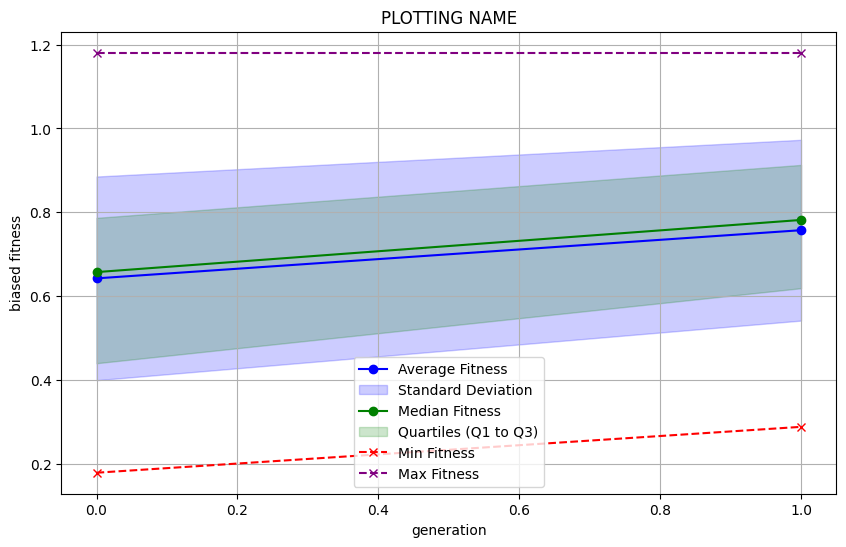

In [3]:
suite.evolution_storage.plot_fitness(
    storage="fitness",
    title="PLOTTING NAME",
    xlabel="generation",
    ylabel="fitness",
)
suite.evolution_storage.plot_fitness(
    storage="biased_fitness",
    title="PLOTTING NAME",
    xlabel="generation",
    ylabel="biased fitness",
)

# 4. Analyze final population(unique)

1. population은 최종 선택된 개체만 남게 됩니다.
2. `population[i]`는 각 VentHole 유전자(Chromosome)이 도출됩니다.
3. `population[i].pattern_matrix` 에는 pattern에 격자화된 point vector가 존재합니다.
3. `population[i].gene_tuple` 을 통해 최종적인 유전자에 접근할 수 있습니다.


## 4.1 Counting chromosome distribution

In [4]:
# Count the number of patterns
import pprint

pp = pprint.PrettyPrinter(indent=4)

pattern: dict = {}
# Count the number of shapes
shapes: dict = {}

# You can choose whole population or unique population
# 1. whole population: suite.population
# 2. unique population: suite.unique_population

for pop in suite.population:
    shape_gene, pattern_gene = pop.gene_tuple
    pattern_label = pattern_gene.param.label.lower()
    shape_label = shape_gene.param.label.lower()

    if pattern_label in pattern:
        pattern[pattern_label] += 1
    else:
        pattern[pattern_label] = 1

    if shape_label in shapes:
        shapes[shape_label] += 1
    else:
        shapes[shape_label] = 1

print("> Pattern Counts")
pp.pprint(pattern)
print("> Shape Counts")
pp.pprint(shapes)

> Pattern Counts
{'circularstricttransformation': 7, 'corntransformation': 41}
> Shape Counts
{   'arrowshape': 3,
    'circleshape': 31,
    'diamondshape': 4,
    'parabolaxrightinnershape': 5,
    'triangleshape': 4,
    'triplerectangleshape': 1}


## 4.2 Visualize top performance patterns

--------------------------------------------------
label: VentHole Chromosome_122: ['CircleShape_146', 'CornTransformation_122']
predict: (0.2892741247800217, 357.4723000630606, 427.3203520884672)
biased_fitness: 1.1682643903896148, fitness: 1.1682643903896148
Design spec: shape parameter

parameter_list: [ r: 1.9437714357800888, ]
Design spec: pattern parameter

parameter_list: [ di: 12.82758360878335, dx: 7.893872843627721, phi: 0.6502167223972088, rot_count: 5.0, ]


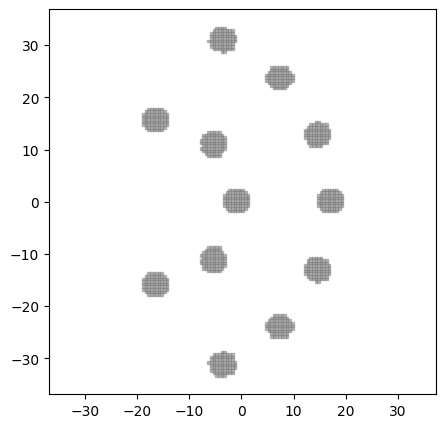

--------------------------------------------------
label: VentHole Chromosome_11: ['ParabolaXRightInnerShape_11', 'CornTransformation_42']
predict: (0.28988223374751954, 366.9805569936729, 427.54307678292844)
biased_fitness: 1.0641310688156964, fitness: 1.0641310688156964
Design spec: shape parameter

parameter_list: [ parabola_xr_inner_a: 7.804522024881238, parabola_xr_inner_b: 3.6327322871135324, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


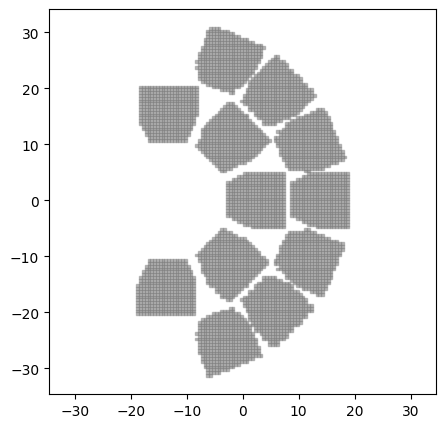

--------------------------------------------------
label: VentHole Chromosome_122: ['CircleShape_47', 'CornTransformation_122']
predict: (0.2903320752264591, 364.6563608657988, 431.5619951439876)
biased_fitness: 1.0292890371575867, fitness: 1.0292890371575867
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


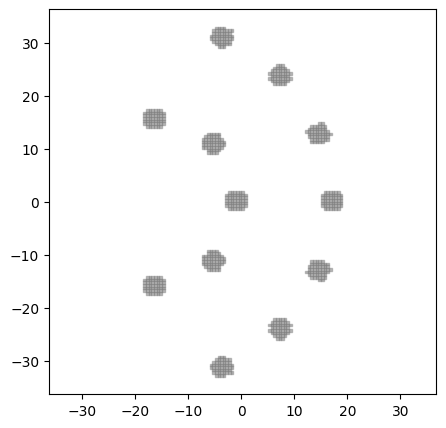

--------------------------------------------------
label: VentHole Chromosome_42: ['CircleShape_146', 'CornTransformation_88']
predict: (0.28943284283322157, 360.9410075196896, 436.96700177348976)
biased_fitness: 1.0033681394910245, fitness: 1.0033681394910245
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


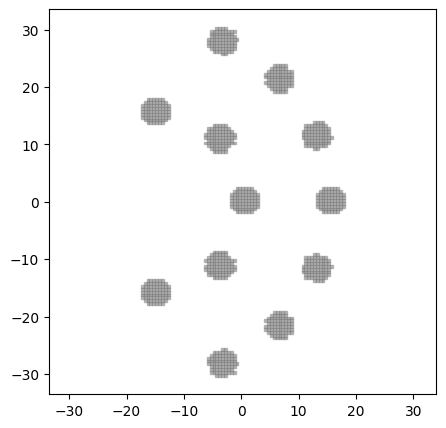

--------------------------------------------------
label: VentHole Chromosome_146: ['CircleShape_63', 'CornTransformation_146']
predict: (0.28943284283322157, 360.9410075196896, 436.96700177348976)
biased_fitness: 1.0033681394910245, fitness: 1.0033681394910245
Design spec: shape parameter

parameter_list: [ r: 1.9437714357800888, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 4.7272127445611565, phi: 0.4007229989611032, rot_count: 5.0, ]


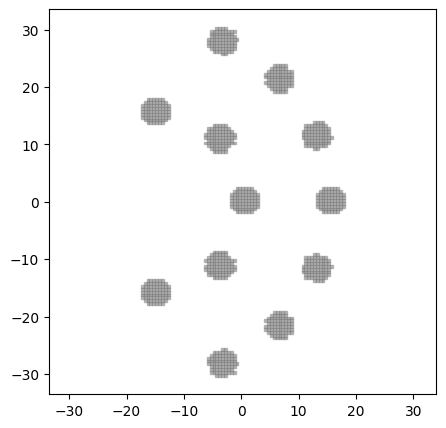

--------------------------------------------------
label: VentHole Chromosome_15: ['CircleShape_143', 'CornTransformation_15']
predict: (0.2898110190306227, 361.7268800310129, 437.85955005387586)
biased_fitness: 0.9798270086652991, fitness: 0.9798270086652991
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


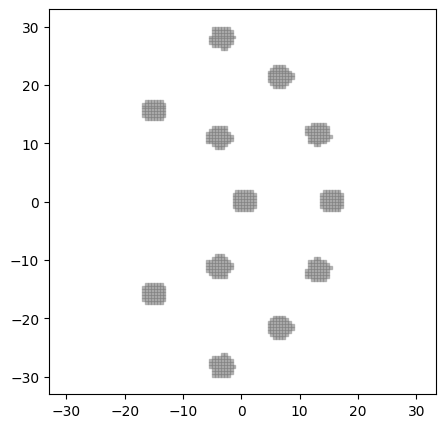

--------------------------------------------------
label: VentHole Chromosome_15: ['CircleShape_88', 'CornTransformation_15']
predict: (0.2898110190306227, 361.7268800310129, 437.85955005387586)
biased_fitness: 0.9798270086652991, fitness: 0.9798270086652991
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


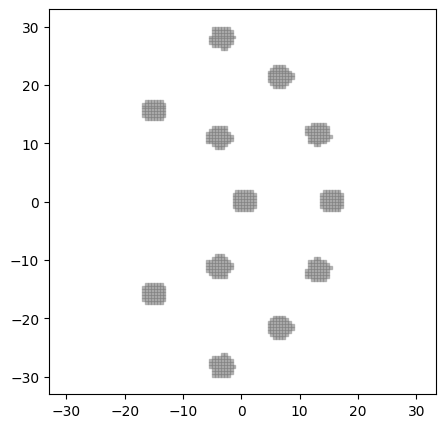

--------------------------------------------------
label: VentHole Chromosome_142: ['ParabolaXRightInnerShape_11', 'CornTransformation_15']
predict: (0.29024787005030817, 367.09914986535284, 435.7024039795733)
biased_fitness: 0.9504977477824121, fitness: 0.9504977477824121
Design spec: shape parameter

parameter_list: [ parabola_xr_inner_a: 7.804522024881238, parabola_xr_inner_b: 3.6327322871135324, ]
Design spec: pattern parameter

parameter_list: [ di: 12.82758360878335, dx: 7.893872843627721, phi: 0.6502167223972088, rot_count: 5.0, ]


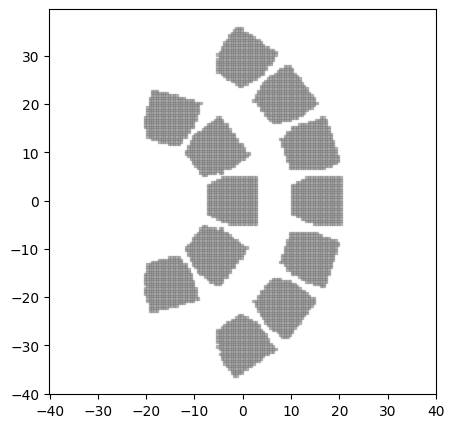

--------------------------------------------------
label: VentHole Chromosome_88: ['CircleShape_88', 'CornTransformation_42']
predict: (0.2904376870601624, 362.4789168611154, 440.06337220019304)
biased_fitness: 0.9366556647846481, fitness: 0.9366556647846481
Design spec: shape parameter

parameter_list: [ r: 1.5826483883898823, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


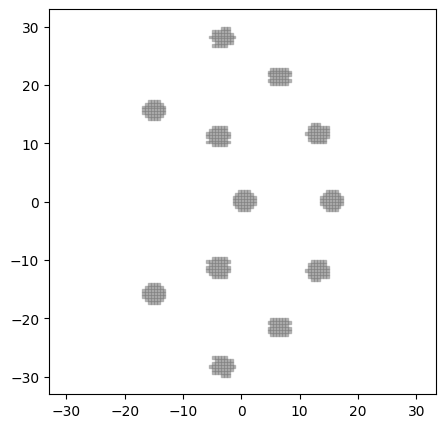

--------------------------------------------------
label: VentHole Chromosome_63: ['CircleShape_63', 'CornTransformation_2']
predict: (0.29058322787476243, 366.7725187014697, 438.5129710616566)
biased_fitness: 0.9129362534155908, fitness: 0.9129362534155908
Design spec: shape parameter

parameter_list: [ r: 1.9437714357800888, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 4.7272127445611565, phi: 0.4007229989611032, rot_count: 5.0, ]


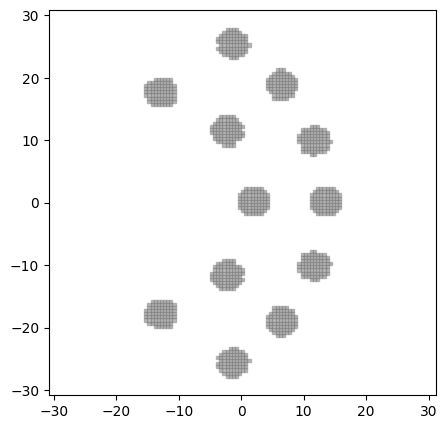

--------------------------------------------------
label: VentHole Chromosome_122: ['DiamondShape_47', 'CornTransformation_19']
predict: (0.29012454698371926, 365.62790482721886, 444.65792428818713)
biased_fitness: 0.8470364913814571, fitness: 0.8470364913814571
Design spec: shape parameter

parameter_list: [ diamond_l: 2.7283208220208994, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


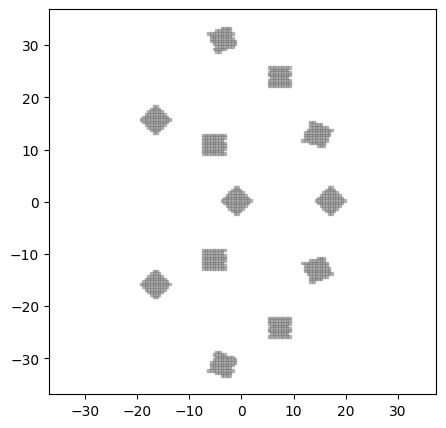

--------------------------------------------------
label: VentHole Chromosome_122: ['CircleShape_63', 'CircularStrictTransformation_142']
predict: (0.2907373799559707, 369.0919607145506, 442.48816321836057)
biased_fitness: 0.8351977503833122, fitness: 0.8351977503833122
Design spec: shape parameter

parameter_list: [ r: 1.9437714357800888, ]
Design spec: pattern parameter

parameter_list: [ di: 9.004660821553859, dx: 2.0109277132987295, phi: 0.6981317007977318, ]


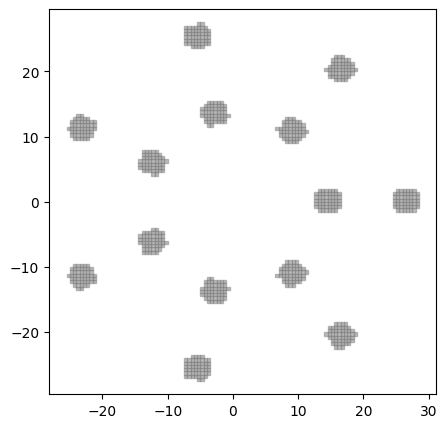

--------------------------------------------------
label: VentHole Chromosome_142: ['CircleShape_15', 'CircularStrictTransformation_122']
predict: (0.2907373799559707, 369.0919607145506, 442.48816321836057)
biased_fitness: 0.8351977503833122, fitness: 0.8351977503833122
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 9.004660821553859, dx: 2.0109277132987295, phi: 0.6981317007977318, ]


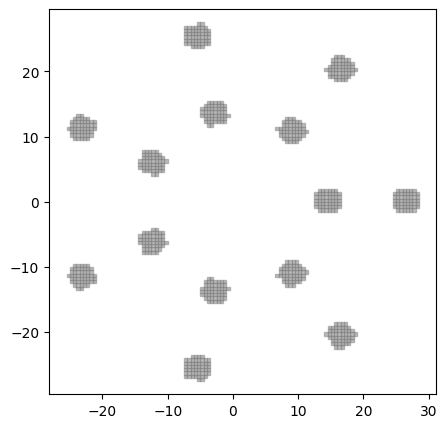

--------------------------------------------------
label: VentHole Chromosome_11: ['ParabolaXRightInnerShape_11', 'CornTransformation_146']
predict: (0.29045160275032345, 369.97780517291733, 443.37765913743715)
biased_fitness: 0.8173371322684302, fitness: 0.8173371322684302
Design spec: shape parameter

parameter_list: [ parabola_xr_inner_a: 7.804522024881238, parabola_xr_inner_b: 3.6327322871135324, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 4.7272127445611565, phi: 0.4007229989611032, rot_count: 5.0, ]


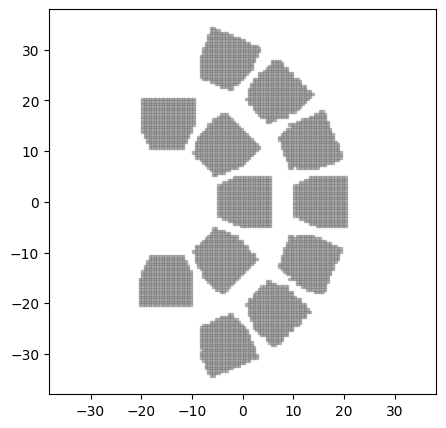

--------------------------------------------------
label: VentHole Chromosome_146: ['CircleShape_42', 'CornTransformation_11']
predict: (0.29049601581867535, 365.67613688261554, 446.7057149917455)
biased_fitness: 0.8155356064304847, fitness: 0.8155356064304847
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


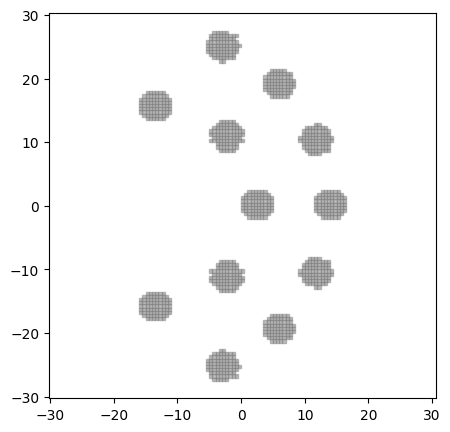

--------------------------------------------------
label: VentHole Chromosome_122: ['DiamondShape_15', 'CornTransformation_143']
predict: (0.29049601581867535, 365.67613688261554, 446.7057149917455)
biased_fitness: 0.8155356064304847, fitness: 0.8155356064304847
Design spec: shape parameter

parameter_list: [ diamond_l: 2.7283208220208994, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


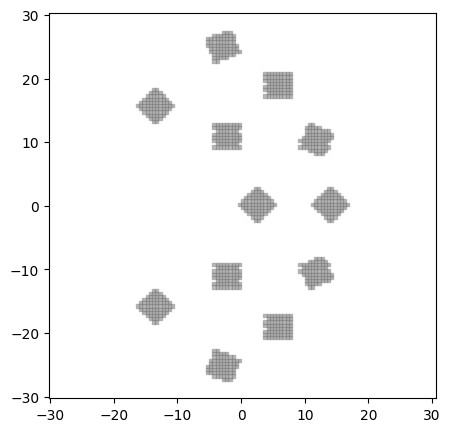

--------------------------------------------------
label: VentHole Chromosome_15: ['CircleShape_15', 'CornTransformation_122']
predict: (0.28981833813628555, 368.05132462343033, 447.34998214064035)
biased_fitness: 0.7899702771943031, fitness: 0.7899702771943031
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 12.82758360878335, dx: 7.893872843627721, phi: 0.6502167223972088, rot_count: 5.0, ]


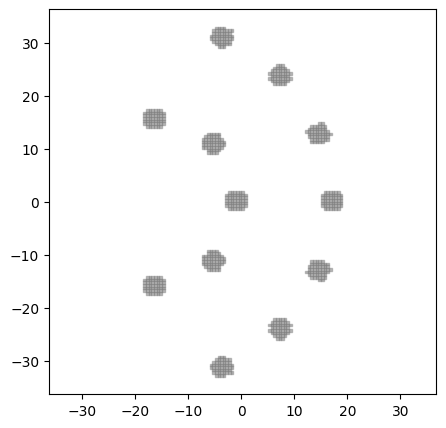

--------------------------------------------------
label: VentHole Chromosome_15: ['CircleShape_35', 'CornTransformation_63']
predict: (0.2903986106140195, 368.206487746073, 446.97533857312374)
biased_fitness: 0.7876111687574252, fitness: 0.7876111687574252
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 4.7272127445611565, phi: 0.4007229989611032, rot_count: 5.0, ]


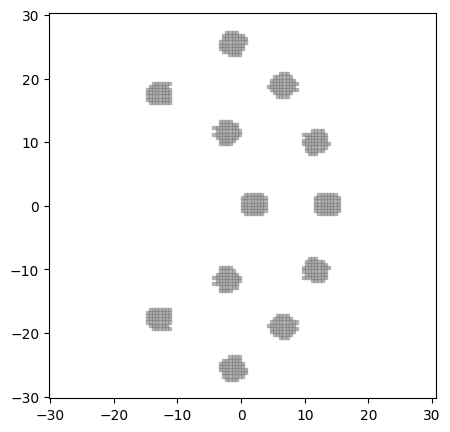

--------------------------------------------------
label: VentHole Chromosome_15: ['ArrowShape_19', 'CornTransformation_42']
predict: (0.2904775170887177, 367.9580331044732, 448.46237245207703)
biased_fitness: 0.7694795320403969, fitness: 0.7694795320403969
Design spec: shape parameter

parameter_list: [ arrow_theta_1: 0.16298620050967125, arrow_theta_2: 0.6986867675436503, arrow_a: 5.207000655868391, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


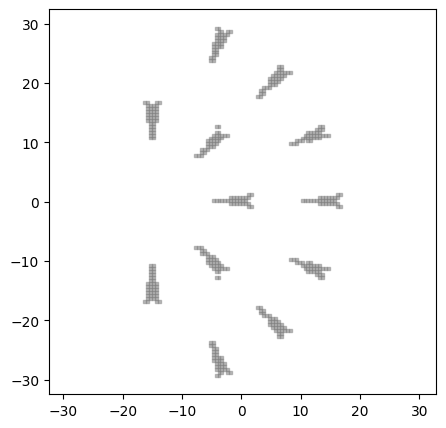

--------------------------------------------------
label: VentHole Chromosome_42: ['CircleShape_122', 'CornTransformation_15']
predict: (0.29043299931984734, 366.5694342687711, 450.4753554320214)
biased_fitness: 0.7569709250201971, fitness: 0.7569709250201971
Design spec: shape parameter

parameter_list: [ r: 1.9437714357800888, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


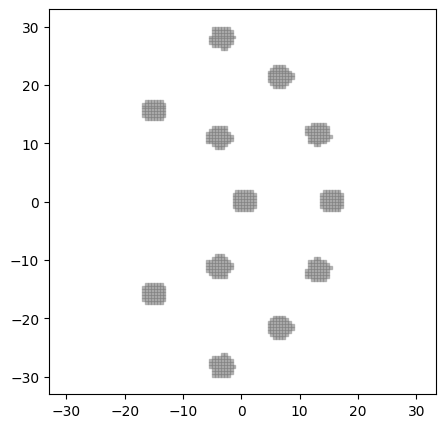

--------------------------------------------------
label: VentHole Chromosome_148: ['ArrowShape_148', 'CornTransformation_51']
predict: (0.2908042026621729, 370.52901371196936, 449.2858496312292)
biased_fitness: 0.7295231745088546, fitness: 0.7295231745088546
Design spec: shape parameter

parameter_list: [ arrow_theta_1: 0.36711558428425084, arrow_theta_2: 1.1101125653627064, arrow_a: 3.47366051921618, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


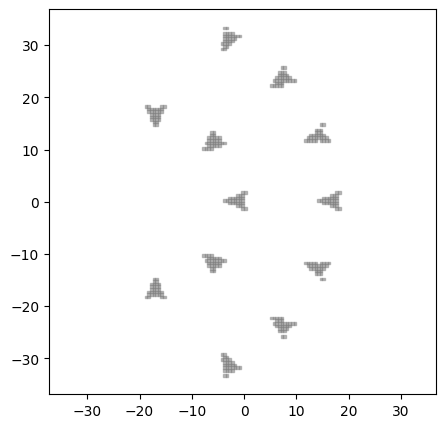

--------------------------------------------------
label: VentHole Chromosome_142: ['DiamondShape_122', 'CircularStrictTransformation_142']
predict: (0.2911531126267022, 372.25411030295083, 449.2802756332967)
biased_fitness: 0.7088574289261804, fitness: 0.7088574289261804
Design spec: shape parameter

parameter_list: [ diamond_l: 2.7283208220208994, ]
Design spec: pattern parameter

parameter_list: [ di: 9.004660821553859, dx: 2.0109277132987295, phi: 0.6981317007977318, ]


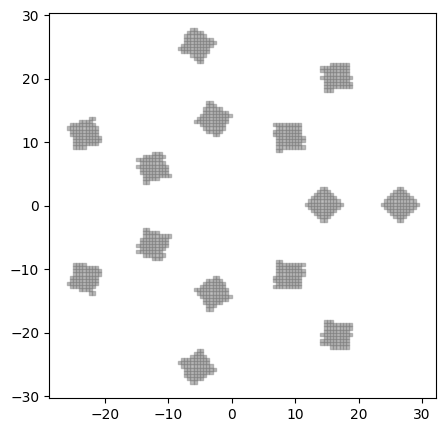

--------------------------------------------------
label: VentHole Chromosome_2: ['TripleRectangleShape_27', 'CircularStrictTransformation_88']
predict: (0.29263160393327325, 383.97908205270545, 442.19720423245417)
biased_fitness: 0.6712637503741572, fitness: 0.6712637503741572
Design spec: shape parameter

parameter_list: [ rect__w: 2.6437438739188432, rect__h: 1.0359345680638667, rect__delta_y: 0.7644287427972646, ]
Design spec: pattern parameter

parameter_list: [ di: 12.50307345620934, dx: 1.6172508378103305, phi: 0.6283185307179586, ]


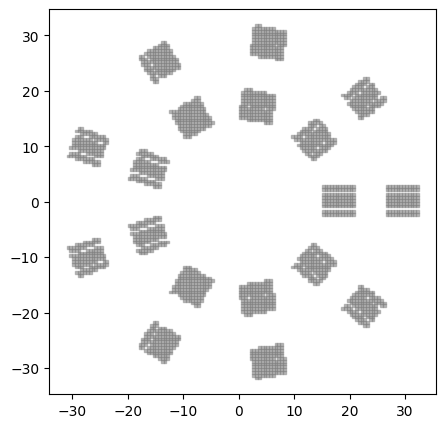

--------------------------------------------------
label: VentHole Chromosome_146: ['CircleShape_15', 'CornTransformation_63']
predict: (0.2907601599587366, 369.38090171839394, 456.10965121100526)
biased_fitness: 0.650460700415291, fitness: 0.650460700415291
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 4.7272127445611565, phi: 0.4007229989611032, rot_count: 5.0, ]


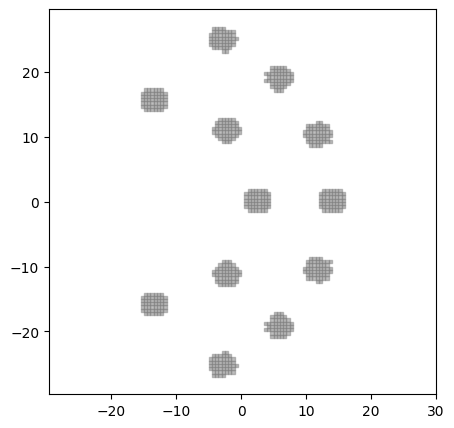

--------------------------------------------------
label: VentHole Chromosome_11: ['TriangleShape_51', 'CornTransformation_133']
predict: (0.2906158691857712, 369.49290065384974, 458.50739727727523)
biased_fitness: 0.6188136712401207, fitness: 0.6188136712401207
Design spec: shape parameter

parameter_list: [ l: 8.103966099965962, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


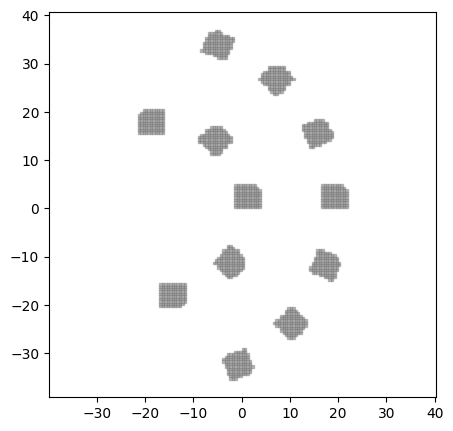

--------------------------------------------------
label: VentHole Chromosome_51: ['TriangleShape_11', 'CornTransformation_19']
predict: (0.2906158691857712, 369.49290065384974, 458.50739727727523)
biased_fitness: 0.6188136712401207, fitness: 0.6188136712401207
Design spec: shape parameter

parameter_list: [ l: 8.103966099965962, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


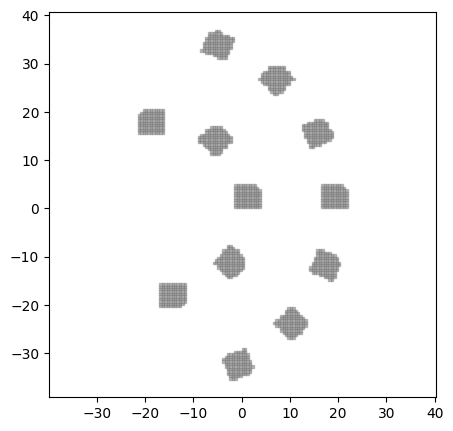

--------------------------------------------------
label: VentHole Chromosome_143: ['CircleShape_47', 'CornTransformation_143']
predict: (0.2905124090724769, 369.1215682526314, 461.57971747997544)
biased_fitness: 0.5825973270159112, fitness: 0.5825973270159112
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 10.180215743692463, dx: 8.002483305782516, phi: 0.4195685936108411, rot_count: 3.0, ]


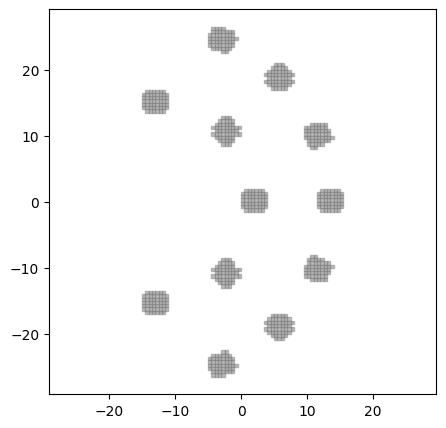

--------------------------------------------------
label: VentHole Chromosome_35: ['CircleShape_122', 'CornTransformation_148']
predict: (0.29071118554223574, 370.9509582810624, 465.17900945739893)
biased_fitness: 0.5143251023350326, fitness: 0.5143251023350326
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 11.494713784904853, dx: 1.4592593443092545, phi: 0.6502167223972088, rot_count: 3.0, ]


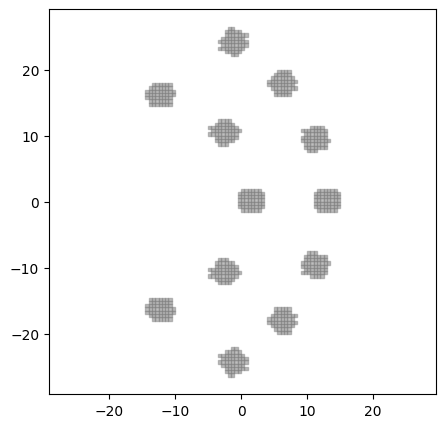

--------------------------------------------------
label: VentHole Chromosome_42: ['ArrowShape_15', 'CornTransformation_19']
predict: (0.2904923008036917, 371.9897769980398, 469.4889115658043)
biased_fitness: 0.44866040110529404, fitness: 0.44866040110529404
Design spec: shape parameter

parameter_list: [ arrow_theta_1: 0.16298620050967125, arrow_theta_2: 0.6986867675436503, arrow_a: 5.207000655868391, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 7.893872843627721, phi: 0.4007229989611032, rot_count: 5.0, ]


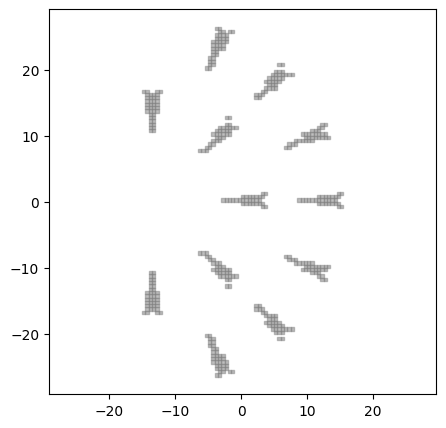

--------------------------------------------------
label: VentHole Chromosome_15: ['TriangleShape_27', 'CornTransformation_11']
predict: (0.2906016350823961, 376.0030906482391, 467.5048741499377)
biased_fitness: 0.4338877540278121, fitness: 0.4338877540278121
Design spec: shape parameter

parameter_list: [ l: 8.103966099965962, ]
Design spec: pattern parameter

parameter_list: [ di: 10.720291186684156, dx: 4.7272127445611565, phi: 0.4007229989611032, rot_count: 5.0, ]


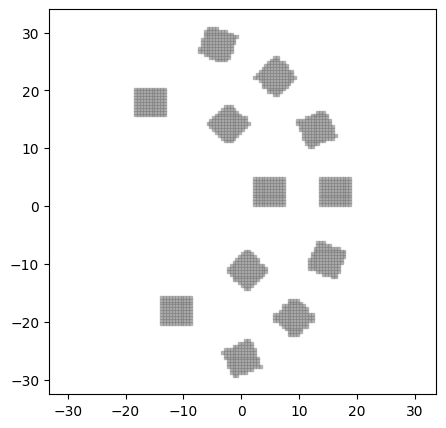

--------------------------------------------------
label: VentHole Chromosome_15: ['CircleShape_15', 'CircularStrictTransformation_63']
predict: (0.2911684904580767, 374.7207627518875, 472.56595886516516)
biased_fitness: 0.3735613496981559, fitness: 0.3735613496981559
Design spec: shape parameter

parameter_list: [ r: 2.343990856889944, ]
Design spec: pattern parameter

parameter_list: [ di: 8.69018413727482, dx: 1.506475720765783, phi: 0.36959913571644626, ]


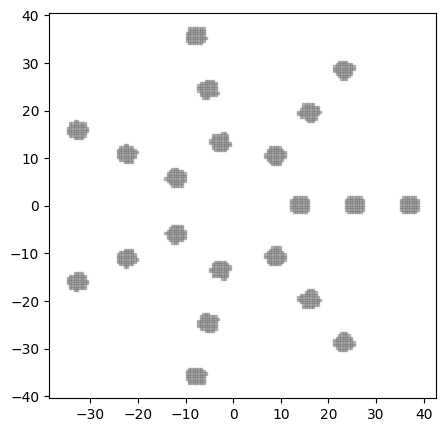

In [5]:
from src.grid.visualize_points import visualize_points

sorted_population = sorted(
    suite.unique_population, key=lambda x: x.fitness, reverse=True
)

for pop in sorted_population:
    print("-" * 50)
    print(f"label: {pop.label}")
    print(f"predict: {pop.fitness_pure_result}")
    print(f"biased_fitness: {pop.biased_fitness}, fitness: {pop.fitness}")

    shape, pattern = pop.gene_tuple
    print("Design spec: shape parameter\n")
    shape.print_parameter_info()
    print("Design spec: pattern parameter\n")
    pattern.print_parameter_info()

    # FIG Size can be adjusted e.g) (3,3) (10, 10), ...
    visualize_points(
        pop.pattern.pattern_matrix,
        pop.pattern.pattern_unit.grid.k,
        fig_size=(5, 5),
    )